In [5]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFECV

In [6]:
files = map(np.load, glob.glob("../export/data/physio_data_*.npz"))

In [7]:
# load data

n_subject = len(files)

skip_sample = 100
n_samples = 1500

inputs_raw = pd.DataFrame()
labels = []

for f in files:
    
    session_info = f["session_info"].tolist()
    
    mediafile = session_info["mediaFile"]
    sid = int(session_info["sessionId"])
    label = int(session_info["feltVlnc"])
    
    print "load data for {}".format(sid)
    
    data = pd.DataFrame()
    
    for signal in ['ecg', 'eda', 'resp', 'skt']:
        data[signal] = f[signal][skip_sample:skip_sample + n_samples]
    
    data["label"] = label
    data["media"] = mediafile
    
    # concatenate all subjects' data
    inputs_raw = pd.concat([inputs_raw, data], ignore_index=True)

load data for 398
load data for 408
load data for 420
load data for 426
load data for 430
load data for 524
load data for 530
load data for 542
load data for 546
load data for 548
load data for 786
load data for 798
load data for 800
load data for 810
load data for 814
load data for 920
load data for 926
load data for 932
load data for 944
load data for 948
load data for 1052
load data for 1054
load data for 1066
load data for 10
load data for 1178
load data for 1188
load data for 1200
load data for 1206
load data for 1210
load data for 132
load data for 142
load data for 152
load data for 1562
load data for 1586
load data for 1588
load data for 1592
load data for 1598
load data for 160
load data for 166
load data for 1698
load data for 1702
load data for 1712
load data for 1714
load data for 1726
load data for 1952
load data for 1956
load data for 1962
load data for 1974
load data for 2086
load data for 2088
load data for 2090
load data for 20
load data for 2100
load data for 2118
loa

In [8]:
print inputs_raw

             ecg       eda      resp       skt  label   media
0       0.941577  0.239769  0.417045  0.110864      2  30.avi
1       0.946434  0.238437  0.408560  0.109673      2  30.avi
2       0.954386  0.237029  0.400151  0.111757      2  30.avi
3       0.959282  0.236110  0.392344  0.110602      2  30.avi
4       0.967196  0.236148  0.384632  0.112656      2  30.avi
5       0.972131  0.236519  0.377528  0.111536      2  30.avi
6       0.980006  0.236659  0.370530  0.113560      2  30.avi
7       0.984976  0.236579  0.364136  0.112474      2  30.avi
8       0.992836  0.236292  0.357852  0.114471      2  30.avi
9       0.997515  0.235815  0.352165  0.113417      2  30.avi
10      1.000000  0.235162  0.346585  0.115386      2  30.avi
11      0.998100  0.234346  0.341587  0.114363      2  30.avi
12      0.999346  0.233381  0.336688  0.116307      2  30.avi
13      0.997629  0.232278  0.332351  0.115314      2  30.avi
14      0.998787  0.231049  0.328100  0.117233      2  30.avi
15      

In [8]:
# split training and validation data
X = inputs_raw.drop(columns=["label", "media"], axis=1)
Y = inputs_raw["label"]

In [9]:
# check and remove Nan values
print X.isna().any()
X.fillna(X.median(), inplace=True)

ecg     False
eda     False
resp    False
skt     False
dtype: bool


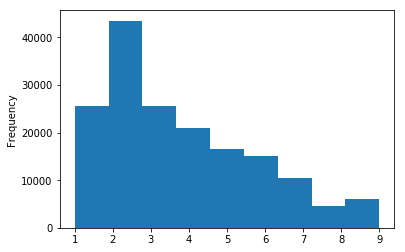

In [10]:
Y.plot.hist(bins=9)

In [11]:
Y[Y==1] = 0
Y[Y==2] = 0
Y[Y==3] = 0
Y[Y==5] = 0
Y[Y==7] = 0
Y[Y==12] = 0

Y[Y==4] = 1
Y[Y==5] = 1
Y[Y==6] = 1
Y[Y==8] = 1
Y[Y==9] = 1
Y[Y==11] = 1

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing import

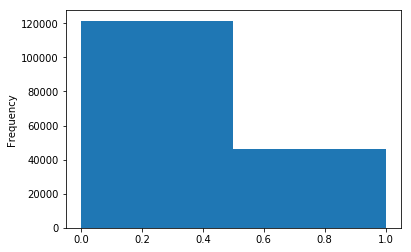

In [12]:
Y.plot.hist(bins=2)

In [13]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_interactions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    # Remove interaction terms with all 0 values            
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis=1)
    
    return df

In [14]:
x_interact = add_interactions(X)
print(x_interact.head(5))

        ecg       eda      resp       skt   ecg_eda  ecg_resp   ecg_skt  \
0  0.941577  0.239769  0.417045  0.110864  0.225761  0.392680  0.104387   
1  0.946434  0.238437  0.408560  0.109673  0.225665  0.386675  0.103799   
2  0.954386  0.237029  0.400151  0.111757  0.226217  0.381898  0.106659   
3  0.959282  0.236110  0.392344  0.110602  0.226496  0.376369  0.106099   
4  0.967196  0.236148  0.384632  0.112656  0.228401  0.372015  0.108960   

   eda_resp   eda_skt  resp_skt  
0  0.099994  0.026582  0.046235  
1  0.097416  0.026150  0.044808  
2  0.094847  0.026490  0.044720  
3  0.092636  0.026114  0.043394  
4  0.090830  0.026603  0.043331  


In [37]:
xtrain, xval, ytrain, yval = train_test_split(x_interact, Y, test_size=.2, shuffle=True)

print xtrain.shape
print ytrain.shape
print xval.shape
print yval.shape

(134400, 10)
(134400,)
(33600, 10)
(33600,)


In [16]:
# Such a large set of features can cause overfitting and also slow computing
# Use feature selection to select the most important features
import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k=5)
selected_features = select.fit(xtrain, ytrain)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [xtrain.columns[i] for i in indices_selected]

xtrain_selected = xtrain[colnames_selected]
xval_selected = xval[colnames_selected]

In [17]:
colnames_selected

['skt', 'ecg_eda', 'ecg_skt', 'eda_skt', 'resp_skt']

## SVC

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [80]:
svc = SVC(C=1, kernel='linear', random_state=0, class_weight='balanced', verbose=True)

n_estimators = 10
bagging = BaggingClassifier(clf, max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1, verbose=True)

bagging.fit(xtrain, ytrain.ravel())
bagging.score(xval,yval)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.7s finished


0.49098214285714287

In [ ]:
svc = SVC(class_weight='balanced', kernel='linear', verbose=True)
svc.fit(xtrain_selected, ytrain.ravel())
svc.score(xval_selected,yval)

## LinearSVC

In [18]:
lsvc = LinearSVC(C=1, tol=0.001, dual=False, fit_intercept=False, max_iter=10000, verbose=True, class_weight='balanced')
lsvc.fit(xtrain, ytrain.ravel())
lsvc.score(xval, yval)

[LibLinear]

0.43970238095238096

In [25]:
lsvc = LinearSVC(C=1, tol=0.001, dual=False, fit_intercept=False, max_iter=10000, verbose=True, class_weight='balanced')
lsvc.fit(xtrain_selected, ytrain.ravel())
lsvc.score(xval_selected, yval)

[LibLinear]

0.5253869047619047

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=n_subject, shuffle=False, random_state=0)
clf = LinearSVC(C=1, tol=0.001, dual=False, fit_intercept=False, max_iter=10000, verbose=True, class_weight='balanced')
scores = cross_val_score(clf, xtrain, ytrain.ravel(), cv=cv, n_jobs=-1, verbose=True)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   54.1s finished


## Recursive feature selection + SVC

In [63]:
from sklearn.model_selection import KFold

In [67]:
clf = LinearSVC(C=1, tol=1e-4, dual=False, fit_intercept=False, class_weight='balanced')
cv = KFold(n_splits=n_subject, shuffle=False, random_state=0)
rfecv = RFECV(clf, step=1, cv=cv, n_jobs=-1, verbose=True)

In [ ]:
rfecv.fit(xtrain, ytrain.values.ravel())

Index([u'ecg_skt'], dtype='object')


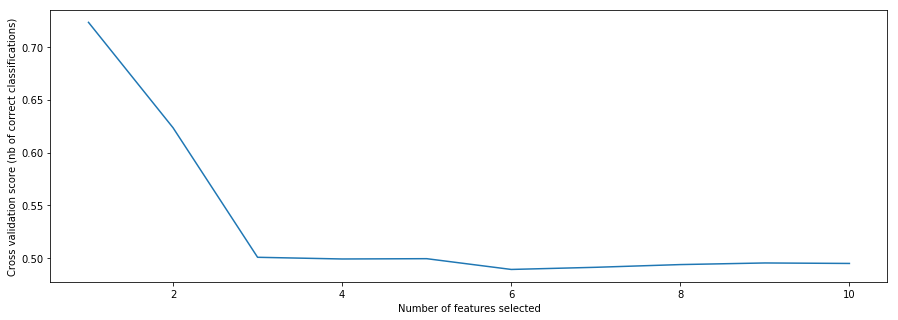

In [77]:
print x_interact.columns[rfecv.get_support()]

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [75]:
scores = rfecv.score(xval, yval)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.00)


# Univariate Feature Selection + SVM

In [33]:
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [45]:
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(xtrain, ytrain)

print x_interact.columns[selector.get_support()]
# scores = -np.log10(selector.pvalues_)
# scores[np.isinf(scores)] = scores[np.isfinite(scores)].max()
# scores /= scores.max()
# plt.bar(np.arange(10), scores, width=.2)
# plt.show()

Index([u'ecg_skt'], dtype='object')


In [46]:
cv = KFold(n_splits=n_subject, shuffle=False, random_state=0)
clf = LinearSVC(C=1, tol=0.001, dual=False, fit_intercept=False, max_iter=10000, verbose=True, class_weight='balanced')
scores = cross_val_score(clf, selector.transform(xtrain), ytrain.values.ravel(), cv=cv, n_jobs=-1, verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   27.6s finished


In [73]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.03)
